In [10]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata2
import math
import string
import tokenize
import sklearn
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn import metrics
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.naive_bayes import MultinomialNB
from string import digits
from xml.dom import minidom
from unidecode import unidecode
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

stop_words = stopwords.words('spanish')
newStopWords = ['dr','dra','etc','bn','ud','u','ag','si','no','rt','q','m','bb','tan','aun','cr','tal','segun','w','lab','aca','wew','av','ah','cll','km','tm','ht','mk','xs','xxl','xl','xxx','reee','nls','kr']
stop_words.extend(newStopWords)
data=pd.read_csv("ScoreV0_int.csv")
sbEsp = SnowballStemmer('spanish')
data.head()

,Tweet,Sentiment
0,Comparto nuestro aliado estrategico para la Es...,5
1,@FREDYGUERRAHERR @consigliererojo @ClaudiaLope...,3
2,@FREDYGUERRAHERR @adelve3 @ClaudiaLopez @Trans...,1
3,@luciabastidasu @TransMilenio Pero esto esta p...,2
4,Lo del bus de TM y la marihuana no esta nada b...,2


In [11]:
data.Sentiment.value_counts()

2    1103
3     528
4     210
1      57
5      38
Name: Sentiment, dtype: int64

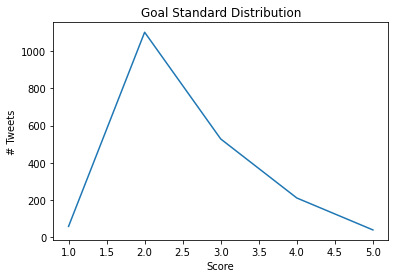

In [12]:
Sentiment_count=data.groupby('Sentiment').count()
fig, ax = plt.subplots()
ax.plot(Sentiment_count)
ax.set(xlabel='Score', ylabel='# Tweets',
       title='Goal Standard Distribution')
fig.savefig("distGoldStandard.png")
plt.show()

In [13]:
def strip_links(text):
    text = text.lower()
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')   
    return text

# Eliminación de Hashtags y menciones
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

# Eliminación de puntuacion, numeros y conversión del texto a minúsculas
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    for digits in string.digits:
        text = text.replace(digits,'')
    text = text.lower()
    return text

def remove_punct(strin):
    strin = strin.translate(str.maketrans('','',string.punctuation));
    strin = strin.translate(str.maketrans('','',string.digits));
    return strin;

#Normalizar: eliminar diéresis, acentos, y otros caracteres similares.
def normunicode_data(strin):
    #print(strin)
    return unicodedata2.normalize('NFKD', strin).encode('ASCII', 'ignore').decode("utf-8").lower()

def proc_str(strin):
    return remove_punct(normunicode_data(strin));

def tok_cln(text):
    return set(nltk.wordpunct_tokenize(text)).difference(stop_words) #(este es el original)

def preprocessing(text):
    text= text.apply(strip_links)
    text= text.apply(strip_all_entities)
    text= text.apply(remove_punctuations)
    text = text.apply(normunicode_data)
    return text

data.Tweet=preprocessing(data["Tweet"])
data.head()

,Tweet,Sentiment
0,comparto nuestro aliado estrategico para la es...,5
1,si se permite esto se acaba la seguridad en bo...,3
2,que hpta desorden de ciudad ya aqui todos hace...,1
3,pero esto esta prohibido normas de convivencia...,2
4,lo del bus de tm y la marihuana no esta nada b...,2


In [5]:
def stemm_data(strin):
    stemmer = SnowballStemmer("spanish");
    return stemmer.stem(strin)  

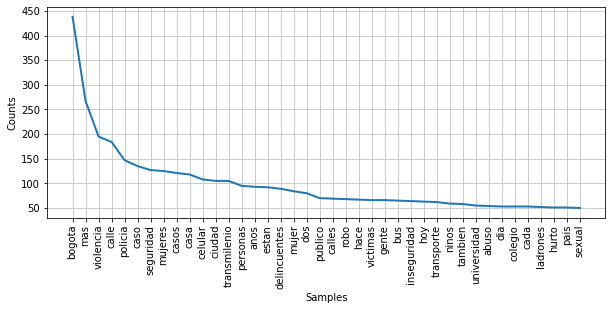

In [17]:
def proc_string(strin,setData):
    resp = set([]);
    for data in tok_cln(proc_str(strin)):
        #tm  = stemm_data(data)
        tm = data
        resp.add(tm)
        if tm in setData:
            setData[tm].add(data)
        else:
            setData[tm] = set([data])
    return ', '.join(resp);

def freq_dist_tok(strin):
    token_clear = strin.apply(tok_cln)
    out = [item for t in token_clear for item in t] 
    fig = plt.figure(figsize = (10,4))
    plt.gcf().subplots_adjust(bottom=0.15)
    fdist = FreqDist(out)
    fdist.plot(40,cumulative=False)
    return fig.savefig('freqDist.png', bbox_inches = "tight")

freq_dist_tok(data.Tweet)

In [19]:
def df2tdm(df,titleColumn,setData):
    listData = [];
    for idx in data.index:        
        listData.append(proc_string(data[titleColumn][idx],setData));
    return listData;

def getDictionary(dfpp): 
    setData = {}
    stinProc = df2tdm(dfpp,'Tweet',setData);
    cv =  CountVectorizer();    
    cv_fit = cv.fit_transform(stinProc);       
    cvCount =  CountVectorizer(cv.vocabulary_);
    # computes the vectorial representation of the CIE10    
    cv_fitCount = cvCount.fit_transform(stinProc);        
    features = cvCount.get_feature_names();    
    return cv,cv_fitCount,features,setData

dfpp = data['Sentiment']
cvQuery_fit,cv_fitCount,features,origTerms = getDictionary (dfpp)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    text_counts, data['Sentiment'], test_size=0.3, random_state=1)

#train_simplevector = BoW_vectorizer.transform(phrase_train)
#test_simplevector = BoW_vectorizer.transform(phrase_test)

In [22]:
clf = MultinomialNB().fit(X_train, y_train)

In [23]:
predicted= clf.predict(X_test)

In [24]:
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.5197934595524957
